<a href="https://colab.research.google.com/github/Shaithra2107/Sentiment_Analysis/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Load the uploaded dataset
file_path = '/content/drive/My Drive/Sentiment Analysis/Tweets.csv'
df = pd.read_csv(file_path)

# Display basic info and first few rows
df_info = df.info()
df_head = df.head()
df_columns = df.columns.tolist()
null_value= df.isnull().sum()

df_info, df_head, df_columns, null_value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

(None,
              tweet_id airline_sentiment  airline_sentiment_confidence  \
 0  570306133677760513           neutral                        1.0000   
 1  570301130888122368          positive                        0.3486   
 2  570301083672813571           neutral                        0.6837   
 3  570301031407624196          negative                        1.0000   
 4  570300817074462722          negative                        1.0000   
 
   negativereason  negativereason_confidence         airline  \
 0            NaN                        NaN  Virgin America   
 1            NaN                     0.0000  Virgin America   
 2            NaN                        NaN  Virgin America   
 3     Bad Flight                     0.7033  Virgin America   
 4     Can't Tell                     1.0000  Virgin America   
 
   airline_sentiment_gold        name negativereason_gold  retweet_count  \
 0                    NaN     cairdin                 NaN              0   
 1       

# Cleaning the data

In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 43.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
import re


nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words


def clean_and_tokenize(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = text.lower()

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and token.is_alpha]
    return " ".join(tokens)



In [ ]:
# Keep only needed columns
df_clean = df[['text', 'airline_sentiment']].dropna()

# Remove empty or whitespace-only texts
df_clean = df_clean[df_clean['text'].str.strip().astype(bool)]

# Encode sentiment
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df_clean['label'] = df_clean['airline_sentiment'].map(label_map)

# Drop rows where label is still null (invalid sentiment)
df_clean = df_clean.dropna(subset=['label'])

# Apply full NLP clean
df_clean['clean_text'] = df_clean['text'].apply(clean_and_tokenize)

# Drop rows where clean_text became empty
df_clean = df_clean[df_clean['clean_text'].str.strip().astype(bool)]

df_clean[['text', 'clean_text', 'airline_sentiment', 'label']].head()



,text,clean_text,airline_sentiment,label
0,@VirginAmerica What @dhepburn said.,say,neutral,1
1,@VirginAmerica plus you've added commercials t...,plus ve add commercial experience tacky,positive,2
2,@VirginAmerica I didn't today... Must mean I n...,not today mean need trip,neutral,1
3,@VirginAmerica it's really aggressive to blast...,aggressive blast obnoxious entertainment guest...,negative,0
4,@VirginAmerica and it's a really big bad thing...,big bad thing,negative,0


# Vectorize the Text

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_clean['clean_text'])
y = df_clean['label']


# Train the data set

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train a Classifier
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

#Evaluation
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1893
           1       0.61      0.46      0.52       573
           2       0.76      0.58      0.66       451

    accuracy                           0.78      2917
   macro avg       0.73      0.65      0.68      2917
weighted avg       0.77      0.78      0.77      2917

Accuracy: 0.7802536852931093


## Model 2  Naive Bayes Classifier for Sentiment

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)


#evaluate

y_pred_nb = nb_model.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_test, y_pred_nb))
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))


              precision    recall  f1-score   support

           0       0.73      0.98      0.84      1893
           1       0.66      0.21      0.32       573
           2       0.83      0.35      0.49       451

    accuracy                           0.73      2917
   macro avg       0.74      0.51      0.55      2917
weighted avg       0.73      0.73      0.68      2917

Naive Bayes Accuracy: 0.7319163524168666


In [ ]:
#Step 1: Apply SMOTE (Synthetic Minority Oversampling)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Apply SMOTE *after* TF-IDF
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Then split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


#Step 2: Hyperparameter Tuning (Naive Bayes)

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

params = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],  # Smoothing values
    'fit_prior': [True, False]
}

nb = MultinomialNB()
grid = GridSearchCV(nb, params, cv=5, scoring='f1_weighted', n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_nb = grid.best_estimator_
print("Best Params:", grid.best_params_)


#Step 3: Evaluate the Tuned Model

from sklearn.metrics import classification_report, accuracy_score

y_pred = best_nb.predict(X_test)
print(classification_report(y_test, y_pred))
print("Tuned Naive Bayes Accuracy:", accuracy_score(y_test, y_pred))


Best Params: {'alpha': 0.1, 'fit_prior': True}
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1835
           1       0.77      0.73      0.75      1812
           2       0.86      0.86      0.86      1852

    accuracy                           0.80      5499
   macro avg       0.80      0.80      0.80      5499
weighted avg       0.80      0.80      0.80      5499

Tuned Naive Bayes Accuracy: 0.8048736133842517


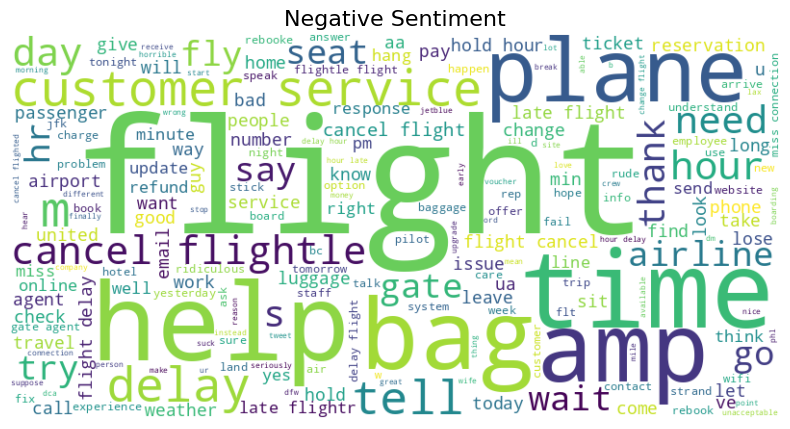

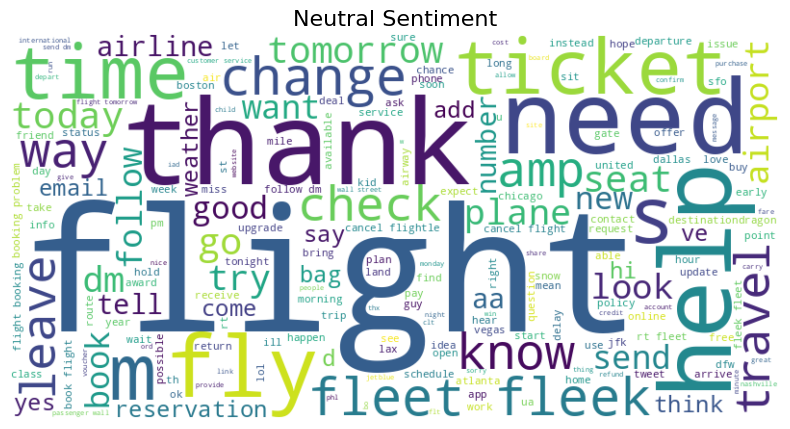

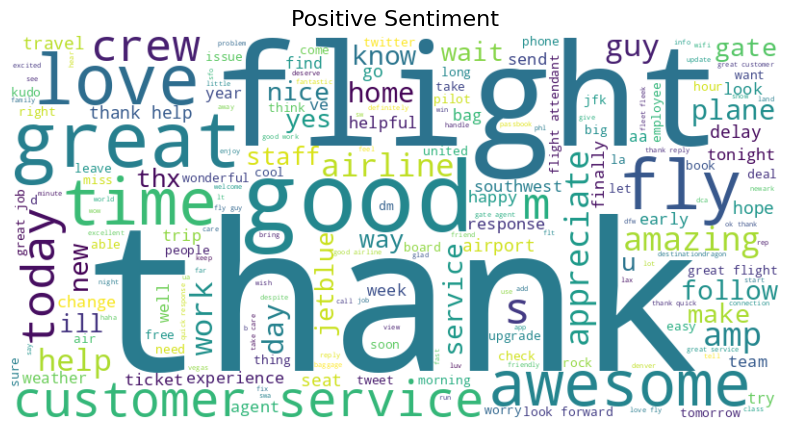

In [ ]:
!pip install wordcloud

#Create Word Clouds by Sentiment

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud
def plot_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# For each class
plot_wordcloud(df_clean[df_clean['label'] == 0]['clean_text'], 'Negative Sentiment')
plot_wordcloud(df_clean[df_clean['label'] == 1]['clean_text'], 'Neutral Sentiment')
plot_wordcloud(df_clean[df_clean['label'] == 2]['clean_text'], 'Positive Sentiment')


In [ ]:
import joblib

# Save the best Naive Bayes model
joblib.dump(best_nb, "sentiment_nb_model.pkl")

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


# Load the model
model = joblib.load("sentiment_nb_model.pkl")

# Load the vectorizer
vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Predict from user input
text = "I love this airline!"
clean_text = clean_and_tokenize(text)
X_input = vectorizer.transform([clean_text])
prediction = model.predict(X_input)

print("Predicted Label:", prediction[0])  # 0=Negative, 1=Neutral, 2=Positive


Predicted Label: 2


In [ ]:
joblib.dump(best_nb, "sentiment_nb_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']